# QLOQ (Qubit Logic on Qudits) – A Hands-On Tutorial

Welcome to this Jupyter Notebook tutorial, where we explore **QLOQ** (Qubit Logic on Qudits) for linear optical quantum computing. We will break down the core concepts behind encoding multiple qubits into a single photon (qudit), demonstrate how **intra-group** gates (like CNOT and single-qubit rotations) are implemented **without** the usual success-probability issues, and show how **Ralph CZ** gates can link multiple qudit blocks.



## Contents

1. [Introduction to QLOQ]
2. [Qudits & CNOT in a Single Photon]
3. [Applying Rotations in a Qudit Group]
4. [Building QLOQ Circuits with Perceval]
5. [Example: Varying Group Sizes & Layers]
6. [Summary]




## 1. Introduction to QLOQ

**QLOQ** (Qubit Logic on Qudits) is a specialized architecture in linear optics that encodes multiple qubits **within a single photon**. Traditionally, a 2-qubit operation in linear optics involves two separate photons interfering at a beam splitter with a probabilistic success rate. However, **QLOQ** circumvents that for intra-group gates by confining both qubits to one photon’s modes.

- **Inter-group** entangling gates (between different photons) still rely on a *Ralph CZ* gate, which is post-selected (probabilistic).
- **Intra-group** gates (like CNOT, CZ, single-qubit rotations) become deterministic mode permutations and transformations.



## 2. Qudits & CNOT in a Single Photon

### Qudits

A **qubit** is a 2-level system |0> or |1>. A **qudit** extends this to \(d\) levels. For a **2-qubit** block, \(d = 4\). We treat each logical basis state as a unique optical mode:
00 → mode 0
01 → mode 1
10 → mode 2
11 → mode 3


A single photon occupying exactly one of these four modes represents any superposition of the 2-qubit space.

### CNOT Within a Qudit

In standard linear optics, a **CNOT** between two separate photons is probabilistic. In QLOQ, if both qubits are in the *same* photon, a CNOT is merely a **mode permutation**:

- |10> ---> |11>
- |00> and |01> remain the same

Hence:

| Mode Index | Binary State | CNOT Output |
|------------|-------------|-------------|
| 0          | 00          | 00          |
| 1          | 01          | 01          |
| 2          | 10          | 11          |
| 3          | 11          | 10          |

This operation is **deterministic** because it’s implemented entirely within the single photon's modes, bypassing the usual success probability constraints.

> **CZ** is similarly done by a mode permutation + Hadamards on the target qubit.




## 3. Applying Rotations in a Qudit Group

## Applying Rotations in a Qudit Group

When **multiple qubits** are encoded into a **single photon** (a qudit), each logical qubit corresponds to a specific **pairing of modes**. For a **2-qubit** group (4 modes total):

- **Modes**:
  **0 → |00⟩**,
  **1 → |01⟩**,
  **2 → |10⟩**,
  **3 → |11⟩**

- **Second qubit** flips between |0> and |1> in the *rightmost bit*, so to rotate it, we **pair**:
  - (0,1) → |00>, |01>
  - (2,3) → |10>, |11>

- **First qubit** flips in the *leftmost bit*, so to rotate it, we **pair**:
  - (0,2) → |00>, |10>
  - (1,3) → |01>, |11>

- So in practice we would apply a 2 mode parametrized beamsplitter for the specific rotation we want to achieve( Rx, Ry, Rz etc ) for each combination corresponding to the qubit we wish to act on.
- Thankfully all this logic and all relevant swaps have been pre-coded into the ansatz builder so the user(you) need not worry too much about them.

> **Key Insight**: **Intra-group operations** are “layerwise,” meaning you stack them: first apply a rotation on the second qubit via parametrized beamsplitters on the correct pairs of modes, then do some internal mode swap, then apply a rotation on the first qubit by doing similarly, etc.



## 4. Building QLOQ Circuits with Perceval

Perceval provides a **`QLOQ ansatz`** that helps you define:

1. **Group Sizes**: e.g., `[Encoding.QUDIT2, Encoding.DUAL_RAIL]`
2. **Layers**: e.g., `["Y", "X"]` for Y then X rotations
3. **Phases**: the numerical angles for each rotation (or `None` for symbolic)
4. **Entangling Gate** (`ctype`): either `"cx"` or `"cz"` inside each group, plus a Ralph CZ across groups.

Below is a minimal code snippet showing how to construct a QLOQ circuit (as a `Processor`) and display it.


Number of required phases: 16


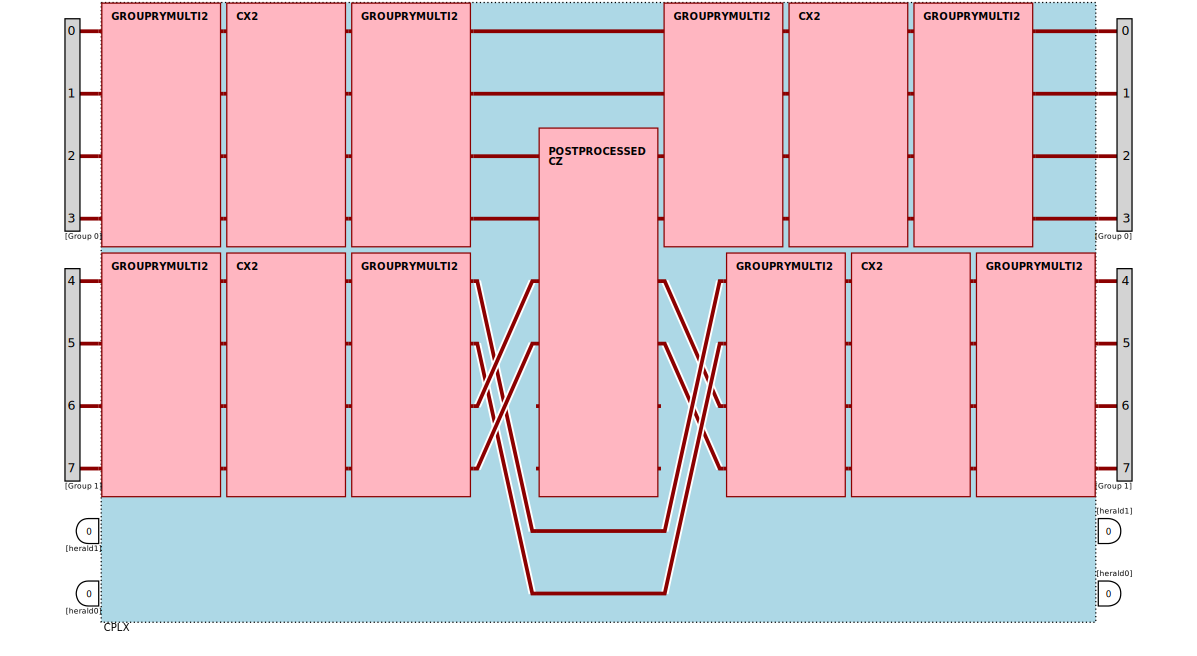

In [1]:

# Example: Building a QLOQ circuit in Perceval

from perceval import pdisplay, catalog, Encoding
from perceval import LogicalState

# 1) Get the QLOQ ansatz from Perceval's catalog
ansatz = catalog["QLOQ ansatz"]

# 2) Define groups of qubits (each group is a qudit)
#    For demonstration: one 2-qubit group (QUDIT2) + one single-qubit group (DUAL_RAIL)
group_sizes = [Encoding.QUDIT2, Encoding.QUDIT2]

# 3) Choose the single-qubit layers we want (Y, X, or Z)
layers = ["Y"]  # e.g., apply Y rotations in each group
#generally Y rotations are sufficient

# 4) Compute how many parameter phases are needed
nb_phases = ansatz.get_parameter_nb(group_sizes, len(layers))
print("Number of required phases:", nb_phases)

# 5) (Optional) Provide numeric phases or use None for symbolic placeholders
phases = None  # Use symbolic parameters for visualization

# 6) Build the QLOQ processor with 'ctype="cx"'
circ = ansatz.build_processor(
    group_sizes=group_sizes,
    layers=layers,
    phases=phases,
    ctype="cx"
)

# 7) Display the resulting circuit
pdisplay(circ, recursive=True)


The ansatz in the qubit picture will then have this form where layers of 2 qubit blocks linked by a multi-controlled Z gate which takes the form of a CCCZ here.

![title](.png)

### Explanation of the Snippet

1. **Catalog & Ansatz**
   - `catalog["QLOQ ansatz"]` fetches the parametric circuit constructor for QLOQ.

2. **Group Sizes**
   - `[Encoding.QUDIT2, Encoding.DUAL_RAIL]` means we have **two** photons:
     - Photon 1: a 2-qubit qudit (4 modes)
     - Photon 2: a 1-qubit dual-rail encoding (2 modes)

3. **Layers**
   - `["Y", "X"]` means each group sees a Y-rotation layer, then an X-rotation layer.

4. **Phases**
   - `ansatz.get_parameter_nb(...)` returns how many numeric angles we need. Setting `phases=None` uses symbolic placeholders.

5. **`ctype="cx"`**
   - Intra-group entangling gates are CNOT-based. They can be set to 'cx' or 'cz' gates. Deterministic and accomplished via swaps.
   - Inter-group entangling gates are accomplished via an unbalanced Ralph CZ to accomplish a CC.....CZ operation. A balanced Ralph CZ has the same success probability(1/9) for each input state. An **unbalanced** version has different success probability for each input. It was chosen because it performs empirically better than the standard CCCZ and requires less post-selected modes.

6. **`pdisplay(circ, recursive=True)`**
   - Shows the circuit structure, including the single-qubit gates and any inter-group connections.


In [2]:


#You can easily change the group sizes or rotation layers:
import perceval as pcvl
from perceval import catalog, Encoding
import numpy as np
from scipy.optimize import minimize
from typing import List, Dict, Tuple, Optional


ansatz = catalog["QLOQ ansatz"]

# Suppose we have three qudit groups:
#   2-qubit (QUDIT2), 2-qubit (QUDIT2), 1-qubit (DUAL_RAIL)
group_sizes = [Encoding.QUDIT2, Encoding.QUDIT2, Encoding.DUAL_RAIL]
#corresponds to 5 qubits

# Let's apply 3 layers: Y, Y, X
layers = ["Y", "Y", "X"]

nb_phases = ansatz.get_parameter_nb(group_sizes, len(layers))
print("New number of required phases:", nb_phases)


New number of required phases: 72





## 6. Summary

**QLOQ** offers a unique way to encode **multiple qubits** in **one photon** (creating qudits). The major advantage is that **CNOTs and single-qubit rotations** within that qudit can be executed deterministically without the usual success probability of two-photon gates. When linking multiple qudit blocks, **Ralph CZ** gates are used, which are **probabilistic** and post-selected.

### Key Points
- **Qudits**: 2 qubits = 4 modes in a single photon, 3 qubits = 8 modes, etc.
- **Intra-group** gates (e.g., CNOT, Ry, Rz, Rx → Mode permutations and layers of beamsplitters.
- **Inter-group** gates → Ralph CZ (post-selected) forming an unbalanced multi-controlled Z.
- **Layerwise approach**: We apply rotations/cnot gates in a sequence of “layers,” possibly swapping modes to target the correct qubit.

In upcoming sections, you can:
- **Integrate** a classical optimizer (e.g., COBYLA) to do VQE-like or QAOA-like tasks on these QLOQ circuits.
- Explore **QUBO** matrices and measure the resulting cost function from the photonic simulator.





## Encoding Functions Explained

These two functions, **`to_fock_state`** and **`fock_to_qubit_state`**, convert between:
1. A **bitstring representation** of qubits (e.g., `"0101"`).
2. A **Fock-state representation** (a list of occupation numbers, eventually wrapped in a `pcvl.BasicState`).

### Key Idea
- **Bitstring**: Represents qubits in the usual binary sense, e.g. `"00"` or `"01"`.
- **Fock State**: In Perceval, a `BasicState` is a list of photon occupation numbers for each mode. A single photon occupying one of \(2^n\) possible modes (for an \(n\)-qubit group) is stored as a one-hot vector (e.g., `[0,1,0,0]` for mode 1 out of 4).

These functions handle situations where **multiple groups** of qubits are each encoded in a **qudit**. For example, a group of **size=2** means 4 modes; a group of **size=3** means 8 modes, etc.

---


In [3]:
def to_fock_state(qubit_state: str, group_sizes: List[int]) -> pcvl.BasicState:
    """
    Convert a multi-qubit bitstring into a Perceval Fock-state representation.

    Args:
        qubit_state: e.g. "0101", a string of bits
        group_sizes: each integer indicates how many qubits in that group
                     (so each group has 2^size possible modes)

    Returns:
        pcvl.BasicState: a one-hot vector indicating the photon's occupation
                         for each group, concatenated across groups.
    """
    offset = 0
    fock_state = []

    for size in group_sizes:
        # If this group has 'size' qubits, we have 2^size modes in it
        if  size != 0:
            group_length = 2 ** size
            # Extract the bits for this group
            group_qubit_state = qubit_state[offset : offset + size]
            # Convert that bitstring to an integer index
            state_index = int(group_qubit_state, 2)
            # Build a one-hot vector of length group_length
            group_fock_state = [1 if i == state_index else 0 for i in range(group_length)]
            fock_state += group_fock_state
            offset += size



    return pcvl.BasicState(fock_state)


def fock_to_qubit_state(fock_state: List[int], group_sizes: List[int]) -> Optional[str]:
    """
    Convert a Perceval Fock-state representation back to a multi-qubit bitstring.

    Args:
        fock_state: a one-hot vector for all groups (concatenated)
        group_sizes: each integer indicates how many qubits are in that group

    Returns:
        A bitstring (e.g. "0101"), or None if the Fock state is invalid.
    """
    # Make a local copy
    fock_state = [i for i in fock_state]

    # Expected total length = sum of (2^group_size) for each group
    expected_length = sum([2 ** size for size in group_sizes])
    if len(fock_state) != expected_length:
        return None

    offset = 0
    qubit_state_binary = ""

    for size in group_sizes:
        group_length = 2 ** size
        group_fock_state = fock_state[offset : offset + group_length]

        # We expect exactly one '1' in the chunk (indicating the photon mode)
        if group_fock_state.count(1) != 1:
            return None

        state_index = group_fock_state.index(1)
        # Convert index to binary (of width 'size' bits)
        binary_state = format(state_index, f'0{size}b')
        qubit_state_binary += binary_state

        offset += group_length

    return qubit_state_binary


### How `to_fock_state` Works

1. **Iterate** over each group in `group_sizes`.
2. For a group of **size = n**, we have \(2^n\) modes.
3. Slice `qubit_state[offset : offset + n]` to get the bits for that group.
   - Example: If `qubit_state="0101"` and the group size = 2, we might take `"01"`.
4. Convert that local bitstring (`"01"`) to an **integer** (`int("01", 2) = 1`).
5. Build a **one-hot** vector of length \(2^n\), placing a `1` at that integer index.
   - E.g. if the index is `1` and `n=2`, that’s `[0,1,0,0]`.
6. Concatenate these one-hot vectors for **all** groups into a single list of occupation numbers.
7. Return `pcvl.BasicState(...)` with that final list.

#### Example 1
- `qubit_state = "0011"`
- `group_sizes = [2,2]`  (two groups, each 2 qubits)

**Step by Step**:
- Group A: size=2 → take `"00"` → `int("00",2) = 0` → one-hot = `[1,0,0,0]`
- Group B: size=2 → take `"11"` → `int("11",2) = 3` → one-hot = `[0,0,0,1]`

Final Fock state = `[1,0,0,0, 0,0,0,1]` → a single photon in mode0 of groupA **and** mode3 of groupB (concatenated).

### How `fock_to_qubit_state` Works

1. **Check** the total length needed: sum of \((2^{\text{group_size}})\).
2. **Slice** each group’s chunk out of the big `fock_state`.
3. Within that chunk, ensure exactly **one** entry is `1`.
4. The **index** of that `1` is the integer representation of the bits for that group.
   - Convert that index to a binary string of width `n`.
5. Append all these binary substrings together, forming the **full** qubit bitstring.

#### Example 2
- `fock_state = [1,0,0,0, 0,0,0,1]` (length=8)
- `group_sizes = [2,2]`

**Step by Step**:
- Group A chunk: `[1,0,0,0]` → exactly one ‘1’ at index=0 → binary of `0` with width=2 → `"00"`
- Group B chunk: `[0,0,0,1]` → index=3 → binary= `"11"`

Concatenate = `"00" + "11"` = `"0011"`.

---

## Edge Cases



1**Invalid Fock State**
   If a chunk has more than one `1` or none at all, `fock_to_qubit_state` returns `None`. This ensures we only accept states with exactly **one** photon per group. Thus, we have post-selected

2**Bitstring Offsets**
   The variable `offset` keeps track of how many bits we’ve already consumed from `qubit_state`. This ensures we map each portion of the bitstring to its corresponding qudit group.

---

By using these helper functions:
- **`to_fock_state`**: you can feed a **bitstring** into a Perceval circuit as the **initial Fock-state input**.
- **`fock_to_qubit_state`**: you can interpret the circuit’s **measurement results** (a one-hot outcome) back into a **bitstring** for classical post-processing or optimization.


# QUBO Example with a Simple QLOQ ansatz Circuit (CVaR-VQE Approach)

In this notebook, we demonstrate how to tackle a **QUBO** (Quadratic Unconstrained Binary Optimization) problem using a **CVar-VQE** style approach in Perceval. This can also be verified with the other more photonic QUBO approach which uses the same QUBO matrix. We’ll show:

1. **How to frame a QUBO problem** and represent it as a matrix  H .
2. **Building a simple QLOQ circuit** (e.g., with Ry layers) to produce a variational ansatz.
3. **Sampling** from the circuit to get a distribution of bitstrings.
4. **Computing CVaR** to measure the cost (objective function) and performing classical optimization (COBYLA).
5. **Identifying the best bitstring** based on the final solution.
6. **Optional**: Plotting the final probability distribution as a histogram for visual insight.

---







## What is CVaR-VQE?

**CVaR-VQE** (Conditional Value-at-Risk Variational Quantum Eigensolver) is a hybrid quantum-classical optimization technique that **goes beyond** the usual average-cost minimization seen in standard VQE:

1. **VQE Recap**
   - In a typical VQE, you prepare a **parametrized quantum circuit** (ansatz).
   - You **sample** from it to estimate the **average** energy (or cost).
   - A **classical optimizer** tunes the circuit parameters to **minimize** this average cost.

2. **Why CVaR?**
   - In many problems, you don’t just care about the **average** cost. You also want to avoid **worst-case** outcomes.
   - **CVaR** (Conditional Value-at-Risk) focuses on the **worst alpha-fraction** of possible outcomes in your distribution.
   - Practically, we *sort* outcomes by cost and *average* the top alpha portion (highest costs). If alpha is 0.5, that means we look at the top 50% of the distribution by cost. By **minimizing** that portion, we make sure the algorithm consistently avoids very high-cost states.

3. **Combining CVaR with VQE**
   - We still build a **variational circuit** and measure its outputs, but instead of updating parameters to reduce the simple average cost, we **focus on the worst tail**.
   - This ensures the final circuit is **less likely** to produce very bad solutions.

In short, **CVaR-VQE** aims to push the distribution of measured bitstrings toward reliably low-cost outcomes, rather than just optimizing the mean. This can be extremely useful for **QUBO** (Quadratic Unconstrained Binary Optimization) problems, where you want to avoid sampling high-cost bitstrings even occasionally.



In [4]:
import perceval as pcvl
from perceval import catalog, Encoding
import numpy as np
from scipy.optimize import minimize
from typing import List, Dict, Tuple, Optional

In [5]:


def compute_cvar(probabilities: List[float], values: List[float], alpha: float) -> float:
    """
    Compute the Conditional Value at Risk (CVaR).
    Given a list of probabilities and corresponding values (costs),
    we take the worst alpha portion of outcomes and average them
    weighted by their probabilities.
    """
    sorted_indices = np.argsort(values)  # sort by ascending value
    probs = np.array(probabilities)[sorted_indices]
    vals = np.array(values)[sorted_indices]
    cvar = 0
    total_prob = 0

    for p, v in zip(probs, vals):
        if p >= alpha - total_prob:
            p = alpha - total_prob
        total_prob += p
        cvar += p * v

    return cvar / total_prob

def expectation_value(vec_state: np.ndarray, qubo_matrix: np.ndarray) -> float:
    """
    Compute the expectation value for a given state with respect to a QUBO matrix.
    Here, vec_state is a binary vector (e.g., [0,1,0,1]) converted to float,
    and qubo_matrix is the NxN matrix of the QUBO.
    """
    return np.dot(vec_state.conjugate(), np.dot(qubo_matrix, vec_state))

def extract_probability_distribution(job_results: Dict, group_sizes: List[int]) -> Tuple[Dict[str, float], int]:
    """
    Extract probability distribution from sampling results.
    Returns:
      output_dict = {bitstring: probability}
      sum_valid_outputs = sum of all valid counts (used for normalization)
    """
    output_dict = {}
    sum_valid_outputs = 0

    # First pass: count how many valid outputs (bitstrings)
    for res in job_results['results']:
        qb_state = fock_to_qubit_state(res, group_sizes)
        if qb_state:
            sum_valid_outputs += job_results['results'][res]

    # Second pass: compute probabilities for each valid bitstring
    for res in job_results['results']:
        qb_state = fock_to_qubit_state(res, group_sizes)
        if qb_state:
            output_dict[qb_state] = job_results['results'][res] / sum_valid_outputs

    return output_dict, sum_valid_outputs


In [6]:


def build_circuit(phases: List[float], group_sizes: List[int], layers: List[str]) -> pcvl.Circuit:
    """
    Build the quantum circuit (QLOQ ansatz) with specified phases.
   
    """
    ansatz = catalog["QLOQ ansatz"]
#    group_sizes_p = [Encoding.QUDIT2 for _ in group_sizes]

    #group_sizes_p = [eval(f"Encoding.QUDIT{x}") for x in group_sizes]
    group_sizes_p = [Encoding.DUAL_RAIL if x == 1 else eval(f"Encoding.QUDIT{x}") for x in group_sizes]
    # Method 1
    
   # group_sizes_p = [Encoding.QUDIT2 for _ in group_sizes]

    proc = ansatz.build_processor(
        group_sizes=group_sizes_p,
        layers=layers,
        phases=phases,
        ctype="cz" #can be cx too
    )
    return proc


In [9]:


def create_objective_function(qubo_matrix: np.ndarray,
                              input_state: str,
                              group_sizes: List[int],
                              layers: List[str],
                              sampling_size: int,
                              alpha: float):
    """
    Create the CVaR-VQE objective function for optimization.
    - qubo_matrix: the QUBO cost matrix
    - input_state: initial computational basis string (e.g. "000000")
    - group_sizes: list of integers, each representing # of qubits in that group
    - layers: e.g. ["Y"] or ["Y","X"]
    - sampling_size: how many shots to gather per evaluation
    - alpha: the fraction for CVaR computation

    Returns:
      objective_function (callable): to be passed into an optimizer
      best_result (list reference): to track the best (lowest) loss + best bitstring
    """
    best_result = [None]  # store (loss, bitstring)
    iteration = [0]       # track iteration count

    def objective_function(phases: np.ndarray) -> float:
        # Ensure phases are in [0, 2π]
        phases_mod = np.mod(phases, 2 * np.pi)

        # Build circuit (processor)
        circ = build_circuit(phases_mod.tolist(), group_sizes, layers)

        # Prepare input state as a Fock state
      #  "000000",[2,2,2]
      #  circ.with_input(to_fock_state(input_state, group_sizes))
        circ.with_input(LogicalState(list(map(int, input_state))))

        # Sample from the circuit
        sampler = pcvl.algorithm.Sampler(circ, max_shots_per_call=sampling_size)
        job = sampler.sample_count
        job_results = job.execute_sync(sampling_size)

        # Extract distribution
        output_dict, _ = extract_probability_distribution(job_results, group_sizes)
        if not output_dict:
            return float('inf')  # if no valid results, large penalty

        # Convert bitstrings to vectors => compute QUBO cost => gather CVaR
        probabilities = list(output_dict.values())
        values = [expectation_value(np.array(list(state)).astype(int), qubo_matrix)
                  for state in output_dict.keys()]

        loss = compute_cvar(probabilities, values, alpha)

        # Track the best result
        bitstring = max(output_dict, key=output_dict.get)
        if best_result[0] is None or loss < best_result[0][0]:
            best_result[0] = (loss, bitstring)

        iteration[0] += 1
        print(f"Iteration {iteration[0]}: Loss = {loss}, Best bitstring = {bitstring}")

        return loss

    return objective_function, best_result


In [10]:


def optimize_qubo(qubo_matrix: np.ndarray,
                  input_state: str,
                  group_sizes: List[int],
                  layers: List[str],
                  sampling_size: int = 100000,
                  alpha: float = 0.5,
                  maxiter: int = 50) -> Tuple[float, str, np.ndarray]:
    """
    Run the optimization using COBYLA to find phases that minimize CVaR for the given QUBO problem.
    - qubo_matrix: your QUBO cost matrix
    - input_state: initial bitstring
    - group_sizes: e.g. [2,2,2]
    - layers: e.g. ["Y"]
    - sampling_size: how many shots per circuit evaluation
    - alpha: fraction for CVaR
    - maxiter: max COBYLA iterations

    Returns:
      final_loss (float): best CVaR found
      best_bitstring (str): best measured bitstring
      optimal_phases (np.ndarray): the phase vector that achieved the best result
    """
    ansatz = catalog["QLOQ ansatz"]
 
    group_sizes_p = [Encoding.DUAL_RAIL if x == 1 else eval(f"Encoding.QUDIT{x}") for x in group_sizes]
    nb_phases = ansatz.get_parameter_nb(group_sizes_p, len(layers))

    # Random initial guess for the phases
    initial_phases = np.random.uniform(0, 2*np.pi, nb_phases)

    # Build the objective function
    objective_function, best_result = create_objective_function(
        qubo_matrix, input_state, group_sizes, layers, sampling_size, alpha
    )

    # Define a custom inequality to keep phases in [0, 2π] if we want
    def constraints(x):
        return np.min(np.array([2 * np.pi - x, x]))

    # Minimize
    result = minimize(
        objective_function,
        initial_phases,
        method='cobyla',
        #constraints={'type': 'ineq', 'fun': constraints},
        options={
            'maxiter': maxiter,
         #   'rhobeg': 0.1,
         #   'rhoend': 1e-6
        }
    )

    best_loss = result.fun
    best_bitstring = best_result[0][1]
    return best_loss, best_bitstring, result.x


In [11]:


import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from typing import Dict

def plot_bitstring_distribution(prob_dict: Dict[str, float], top_n: int = 10, title: str = "Top Bitstring Probabilities"):
    """
    Plot a histogram of the top N most probable bitstrings.

    Args:
        prob_dict: e.g. {"000000": 0.25, "100100": 0.15, ...}
        top_n: how many top states to display
        title: plot title
    """
    # Convert dict to list of (bitstring, probability) pairs
    items = list(prob_dict.items())

    # Sort descending by probability
    items.sort(key=lambda x: x[1], reverse=True)

    # Take the top 'top_n' states
    items = items[:top_n]

    # Unzip into two lists
    bitstrings, probs = zip(*items)

    plt.figure(figsize=(8, 4))
    plt.bar(bitstrings, probs, color='darkviolet')
    plt.ylabel("Probability")
    plt.xlabel("Bitstring")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()



## Putting It All Together

Below is a complete **example** usage, showing how to:

1. Define a sample QUBO matrix (6-qubit problem).
2. Optimize using Ry layers in a QLOQ circuit.
3. Print the final result and best bitstring.
4. Optionally, sample the final circuit once more to plot the output distribution.


Iteration 1: Loss = -1.8786533333333344, Best bitstring = 000011
Iteration 2: Loss = -4.795973333333333, Best bitstring = 001011
Iteration 3: Loss = -12.376706666666667, Best bitstring = 000011
Iteration 4: Loss = -8.182566666666666, Best bitstring = 001011
Iteration 5: Loss = -6.623506666666667, Best bitstring = 000011
Iteration 6: Loss = -21.015766666666668, Best bitstring = 011011
Iteration 7: Loss = -21.27556, Best bitstring = 011011
Iteration 8: Loss = -14.879753333333337, Best bitstring = 011000
Iteration 9: Loss = -21.044606666666667, Best bitstring = 011011
Iteration 10: Loss = -21.501546666666666, Best bitstring = 011101
Iteration 11: Loss = -21.454886666666667, Best bitstring = 011011
Iteration 12: Loss = -21.475546666666666, Best bitstring = 011011
Iteration 13: Loss = -21.216193333333333, Best bitstring = 011011
Iteration 14: Loss = -7.7659333333333365, Best bitstring = 111101
Iteration 15: Loss = -17.53072666666667, Best bitstring = 011101
Iteration 16: Loss = -18.06902000

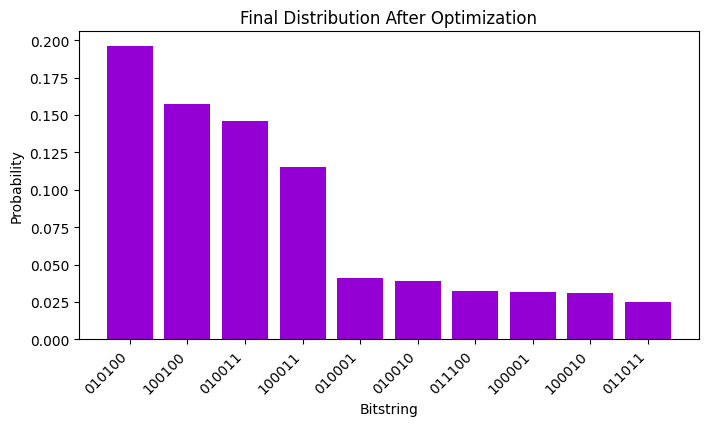

In [12]:


if __name__ == "__main__":
    # Example QUBO matrix (6-qubit)
    H1 = np.array([
        [2.,   32., -32., -32.,  32.,   0.],
        [0.,    1.,  32.,   0., -32., -32.],
        [0.,    0.,  35.,  32., -64., -32.],
        [0.,    0.,   0.,   2., -32.,  32.],
        [0.,    0.,   0.,   0.,  35.,  32.],
        [0.,    0.,   0.,   0.,   0.,   4.]
    ])

    # We'll group the 6 qubits into 2 groups of 3 qubits each: [3,3], [2,2,2], [5,1], [4,2], [3,1,1] etc
    # different group combinations may have different alpha value or sample number needs so play around with different hyperparameters
    group_sizes = [3,3]

    # Single rotation layer: ["Y"]
    layers = ["Y"]

    # Run the optimization
    final_loss, best_bitstring, optimal_phases = optimize_qubo(
        qubo_matrix=H1,
        input_state="000000",     # e.g. 6-qubit input in |000000>
        group_sizes=group_sizes,
        layers=layers,
        sampling_size=1000000,    # how many shots for sampling
        alpha=0.15,                # CVaR parameter
        maxiter=400               # COBYLA iterations
    )

    print("\n=== Final Optimization Results ===")
    print(f"Final CVaR Loss: {final_loss}")
    print(f"Best Bitstring: {best_bitstring}")
    print(f"Optimal Phases: {optimal_phases}")

    # OPTIONAL: Sample final circuit with the found phases, then plot the output distribution
    circ = build_circuit(list(optimal_phases), group_sizes, layers)
    circ.with_input(to_fock_state("000000", group_sizes))
    sampler = pcvl.algorithm.Sampler(circ, max_shots_per_call=100000)
    job = sampler.sample_count
    job_results = job.execute_sync(100000)

    output_dict, _ = extract_probability_distribution(job_results, group_sizes)
    plot_bitstring_distribution(output_dict, title="Final Distribution After Optimization")


### Explanation

1. **`optimize_qubo`** calls our **objective function** repeatedly, adjusting phases to reduce the **CVaR** of the QUBO cost.
2. **`alpha`** in **CVaR** picks how much “worst tail” of outcomes we average over. alpha = 0.5 is a middle ground.
3. **`best_bitstring`** is chosen from the final distribution’s highest-probability outcome (in practice, you might also check the distribution).
4. The **plot** helps visualize which bitstrings are being sampled at the end of optimization.

---

With this approach, you have a working **CVaR-VQE** routine for **QUBO** problems using an ansatz in the **QLOQ** framework. You can expand this by:
- Increasing the number of **layers** (e.g., `["Y","Y"]`).
- Using **CX** gates instead of CZ inside groups (`ctype="cx"`).
- Changing **group_sizes** or QUBO matrix to match your real problem.
- Exploring advanced optimization methods or different cost functions beyond QUBO.

This completes our demonstration of a **QUBO** problem solved by a **CVar-VQE**-like approach in **Perceval’s QLOQ** environment. QLOQ can be applied to various problems involving a variational circuit so it is recommended to refactor this example to your needs whether by changing the loss function to match your given problem or the circuit structure itself.




In [230]:
pcvl.__version__

'0.11.2.post45+2025.1.13'